In [573]:
import pandas as pd

# Load datasets
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
submission = pd.read_csv("Submission.csv")

# Show shapes
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print("Submission shape:", submission.shape)

# Preview first rows
display(train.head())
display(test.head())
display(submission.head())


Train shape: (14699, 14)
Test shape: (300, 14)
Submission shape: (300, 1)


,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,traffic_congestion_level,pickup_borough,dropoff_borough,tolls_amount,tip_amount,fare_estimate,trip_distance_miles
0,3/22/24 9:10,3/22/24 9:23,40.690045,-74.239699,40.704018,-74.214368,2,high,Other,Other,0.00,0.14,18.40,10.9422
1,8/14/24 10:48,8/14/24 10:52,40.763224,-74.053604,40.759277,-74.066002,1,medium,Other,Other,0.00,1.36,9.99,1.2817
2,6/17/24 3:47,6/17/24 3:55,40.658970,-74.179122,40.628631,-74.180385,1,low,Other,Staten Island,5.67,2.36,20.22,13.8034
3,6/25/24 0:45,6/25/24 1:04,40.696980,-73.773970,40.670444,-73.838194,2,medium,Brooklyn,Brooklyn,0.00,3.80,29.73,24.2266
4,6/10/24 4:10,6/10/24 4:14,40.580638,-73.788101,40.594286,-73.780625,3,low,Brooklyn,Brooklyn,0.00,2.68,11.05,3.4222


,pickup_datetime,dropoff_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,traffic_congestion_level,pickup_borough,dropoff_borough,tolls_amount,tip_amount,fare_estimate,trip_distance_miles
0,1/28/24 17:44,1/28/24 18:03,40.855567,-74.244521,40.891126,-74.208418,2,low,Bronx,Bronx,0.0,6.67,26.69,NaN
1,11/27/24 11:37,11/27/24 11:45,40.895791,-74.190683,40.875638,-74.196187,1,medium,Bronx,Bronx,0.0,2.78,11.21,NaN
2,5/11/24 2:48,5/11/24 3:04,40.820683,-74.163929,40.867325,-74.221284,1,low,Bronx,Bronx,0.0,4.07,27.73,NaN
3,3/11/24 18:05,3/11/24 18:33,40.685081,-73.774795,40.640616,-73.744560,1,high,Brooklyn,Brooklyn,0.0,1.93,32.63,NaN
4,9/3/24 1:13,9/3/24 1:26,40.645333,-73.990859,40.607227,-74.009520,4,low,Other,Other,0.0,6.12,20.05,NaN


,trip_distance_miles
0,20.575319
1,7.309726
2,24.422636
3,22.407634
4,19.071991


In [574]:
# Features known to cause data leakage
leakage_cols = ['tip_amount', 'tolls_amount', 'fare_estimate', 'dropoff_datetime', 'traffic_congestion_level']

# Drop from train dataset
cols_to_drop_train = [col for col in leakage_cols if col in train.columns]
train.drop(columns=cols_to_drop_train, inplace=True)

# Drop from test dataset
cols_to_drop_test = [col for col in leakage_cols if col in test.columns]
test.drop(columns=cols_to_drop_test, inplace=True)

# Drop from submission dataset (if any exist there)
cols_to_drop_sub = [col for col in leakage_cols if col in submission.columns]
submission.drop(columns=cols_to_drop_sub, inplace=True)

print("Dropped from train:", cols_to_drop_train)
print("Dropped from test:", cols_to_drop_test)
print("Dropped from submission:", cols_to_drop_sub)

print("\nRemaining columns in train:", train.columns.tolist())


Dropped from train: ['tip_amount', 'tolls_amount', 'fare_estimate', 'dropoff_datetime', 'traffic_congestion_level']
Dropped from test: ['tip_amount', 'tolls_amount', 'fare_estimate', 'dropoff_datetime', 'traffic_congestion_level']
Dropped from submission: []

Remaining columns in train: ['pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'pickup_borough', 'dropoff_borough', 'trip_distance_miles']


In [575]:
datetime_format = '%m/%d/%y %H:%M'

train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'], format=datetime_format, errors='coerce')
# train['dropoff_datetime'] = pd.to_datetime(train['dropoff_datetime'], format=datetime_format, errors='coerce')

test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'], format=datetime_format, errors='coerce')
# test['dropoff_datetime'] = pd.to_datetime(test['dropoff_datetime'], format=datetime_format, errors='coerce')

In [576]:
train['pickup_datetime'].isna().sum()
test['pickup_datetime'].isna().sum()

np.int64(0)

In [577]:
def add_datetime_features(df):
    df['pickup_year'] = df['pickup_datetime'].dt.year
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute
    df['pickup_dayofweek'] = df['pickup_datetime'].dt.dayofweek  # Monday=0, Sunday=6
    df['is_weekend'] = (df['pickup_dayofweek'] >= 5).astype(int)
    
    
    # Trip duration in minutes (for train only — test has no dropoff)
    # if 'dropoff_datetime' in df.columns:
        # df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60
    
    return df

train = add_datetime_features(train)
test = add_datetime_features(test)

In [578]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    R = 3959  # Earth radius in miles
    
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

train['distance_miles'] = haversine(train['pickup_latitude'], train['pickup_longitude'],
                                    train['dropoff_latitude'], train['dropoff_longitude'])

test['distance_miles'] = haversine(test['pickup_latitude'], test['pickup_longitude'],
                                   test['dropoff_latitude'], test['dropoff_longitude'])

In [579]:
# train[['distance_miles', 'pickup_hour', 'pickup_dayofweek']].head()

def near_airport(lat, lon, airport_lat, airport_lon, radius=1.0):
    return (haversine(lat, lon, airport_lat, airport_lon) <= radius).astype(int)

# JFK
train['near_JFK_pickup'] = near_airport(train['pickup_latitude'], train['pickup_longitude'], 40.6413, -73.7781)
train['near_JFK_drop'] = near_airport(train['dropoff_latitude'], train['dropoff_longitude'], 40.6413, -73.7781)

# LGA
train['near_LGA_pickup'] = near_airport(train['pickup_latitude'], train['pickup_longitude'], 40.7769, -73.8740)
train['near_LGA_drop'] = near_airport(train['dropoff_latitude'], train['dropoff_longitude'], 40.7769, -73.8740)

# EWR
train['near_EWR_pickup'] = near_airport(train['pickup_latitude'], train['pickup_longitude'], 40.6895, -74.1745)
train['near_EWR_drop'] = near_airport(train['dropoff_latitude'], train['dropoff_longitude'], 40.6895, -74.1745)

# For Test Data also - same function will work
test['near_JFK_pickup'] = near_airport(test['pickup_latitude'], test['pickup_longitude'], 40.6413, -73.7781)
test['near_JFK_drop'] = near_airport(test['dropoff_latitude'], test['dropoff_longitude'], 40.6413, -73.7781)

test['near_LGA_pickup'] = near_airport(test['pickup_latitude'], test['pickup_longitude'], 40.7769, -73.8740)
test['near_LGA_drop'] = near_airport(test['dropoff_latitude'], test['dropoff_longitude'], 40.7769, -73.8740)

test['near_EWR_pickup'] = near_airport(test['pickup_latitude'], test['pickup_longitude'], 40.6895, -74.1745)
test['near_EWR_drop'] = near_airport(test['dropoff_latitude'], test['dropoff_longitude'], 40.6895, -74.1745)


In [580]:
# Same Borough Feature
train['same_borough'] = (train['pickup_borough'] == train['dropoff_borough']).astype(int)
test['same_borough'] = (test['pickup_borough'] == test['dropoff_borough']).astype(int)

# Manhattan Flag
train['pickup_is_Manhattan'] = (train['pickup_borough'] == "Manhattan").astype(int)
train['drop_is_Manhattan'] = (train['dropoff_borough'] == "Manhattan").astype(int)

test['pickup_is_Manhattan'] = (test['pickup_borough'] == "Manhattan").astype(int)
test['drop_is_Manhattan'] = (test['dropoff_borough'] == "Manhattan").astype(int)

# Don't removereqd further during the clustering process
# original pickup/dropoff lat/long to simplify model and reduce noise

# cols_to_drop = ['pickup_latitude', 'pickup_longitude',
#                 'dropoff_latitude', 'dropoff_longitude']

# train.drop(columns=cols_to_drop, inplace=True)
# test.drop(columns=cols_to_drop, inplace=True)


In [526]:
def add_time_features(df):
    # Create rush hour feature (weekday & peak hours)
    df['is_rush_hour'] = (
        (df['pickup_day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])) &
        (df['pickup_hour'].between(7, 10) | df['pickup_hour'].between(16, 19))
    ).astype(int)
    
    return df

# Apply to both train & test
train = add_time_features(train)
test = add_time_features(test)


In [527]:
# # More passengers often mean longer stops or slower ride
# train['dist_passenger_ratio'] = train['distance_miles'] / (train['passenger_count'] + 1)
# test['dist_passenger_ratio'] = test['distance_miles'] / (test['passenger_count'] + 1)

# # Log Distance (stabilizes variance)

# train['log_distance'] = np.log1p(train['distance_miles'])
# test['log_distance'] = np.log1p(test['distance_miles'])
# # train.columns

cols_to_remove = ['dist_passenger_ratio', 'log_distance']
train.drop(columns=cols_to_remove, errors='ignore', inplace=True)
test.drop(columns=cols_to_remove, errors='ignore', inplace=True)


In [528]:
# # # # Borough Features (convert to numbers)

# # # from sklearn.preprocessing import LabelEncoder

# # # le_pickup = LabelEncoder()
# # # le_drop = LabelEncoder()

# # # train['pickup_borough_enc'] = le_pickup.fit_transform(train['pickup_borough'])
# # # train['dropoff_borough_enc'] = le_drop.fit_transform(train['dropoff_borough'])
# # # test['pickup_borough_enc'] = le_pickup.transform(test['pickup_borough'])
# # # test['dropoff_borough_enc'] = le_drop.transform(test['dropoff_borough'])

# # train.drop(columns=['pickup_borough_enc', 'dropoff_borough_enc'], errors='ignore', inplace=True)
# # test.drop(columns=['pickup_borough_enc', 'dropoff_borough_enc'], errors='ignore', inplace=True)

# train = pd.get_dummies(train, columns=['pickup_borough', 'dropoff_borough'], drop_first=True)
# test = pd.get_dummies(test, columns=['pickup_borough', 'dropoff_borough'], drop_first=True)

# train, test = train.align(test, join='left', axis=1)
# test.fillna(0, inplace=True)  # fix any missing dummy columns

train.drop(columns=['pickup_borough_enc', 'dropoff_borough_enc'], errors='ignore', inplace=True)
test.drop(columns=['pickup_borough_enc', 'dropoff_borough_enc'], errors='ignore', inplace=True)

train = pd.get_dummies(train, columns=['pickup_borough', 'dropoff_borough'], drop_first=True)
test = pd.get_dummies(test, columns=['pickup_borough', 'dropoff_borough'], drop_first=True)

train, test = train.align(test, join='left', axis=1)
test.fillna(0, inplace=True)

In [529]:
# if 'pickup_datetime' in train.columns:
#     train.drop(columns=['pickup_datetime'], inplace=True)

# if 'pickup_datetime' in test.columns:
#     test.drop(columns=['pickup_datetime'], inplace=True)

# # print(train.isnull().sum())
# # print(test.isnull().sum())


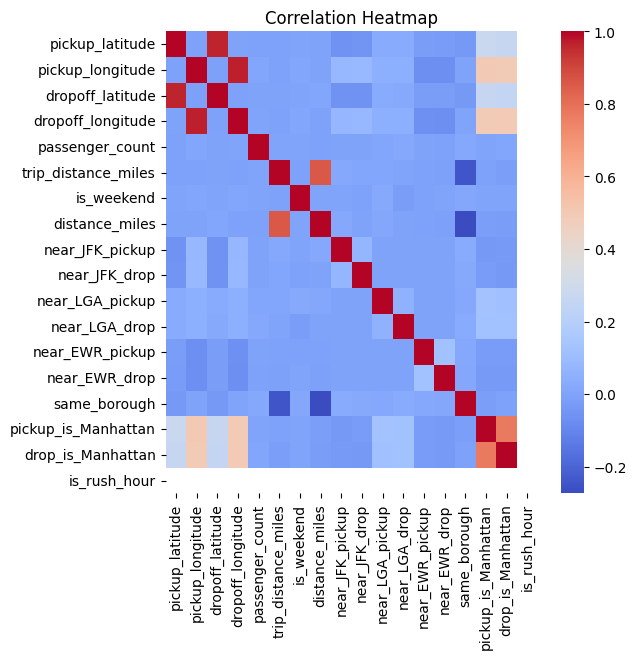

In [530]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(6, 6))
sns.heatmap(train[numeric_cols].corr(), annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [531]:
numeric_cols = train.select_dtypes(include=['number']).columns
train[numeric_cols].corr()['trip_distance_miles'].sort_values(ascending=False)

trip_distance_miles    1.000000
distance_miles         0.860327
near_JFK_pickup        0.019317
near_LGA_pickup        0.007804
pickup_day             0.006439
pickup_month           0.006254
near_JFK_drop          0.006169
passenger_count        0.003636
near_LGA_drop          0.003022
dropoff_latitude      -0.001130
pickup_dayofweek      -0.005931
pickup_longitude      -0.006374
pickup_latitude       -0.006858
pickup_hour           -0.007083
dropoff_longitude     -0.007142
is_weekend            -0.008075
pickup_minute         -0.008075
near_EWR_pickup       -0.008534
pickup_is_Manhattan   -0.008772
near_EWR_drop         -0.010408
drop_is_Manhattan     -0.016431
same_borough          -0.246718
pickup_year                 NaN
is_rush_hour                NaN
Name: trip_distance_miles, dtype: float64

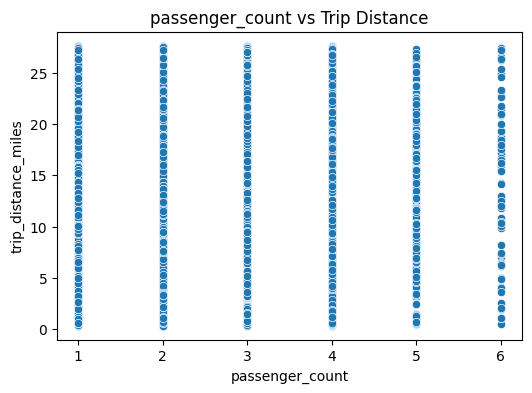

In [532]:
features_to_plot = ['fare_estimate', 'passenger_count', 'log_distance']

for col in features_to_plot:
    if col in train.columns:
        plt.figure(figsize=(6,4))
        sns.scatterplot(data=train, x=col, y='trip_distance_miles')
        plt.title(f"{col} vs Trip Distance")
        plt.show()

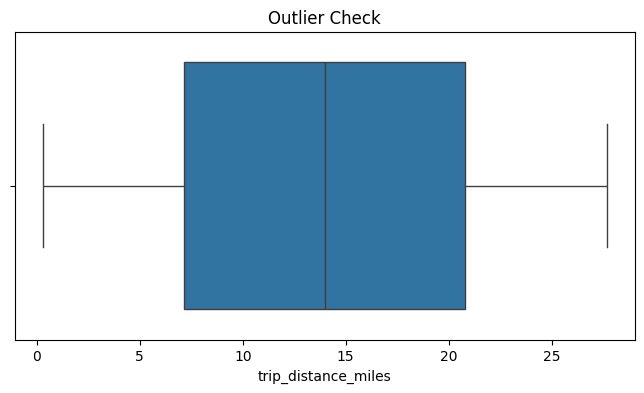

In [533]:
plt.figure(figsize=(8,4))
sns.boxplot(x=train['trip_distance_miles'])
plt.title("Outlier Check")
plt.show()

In [534]:
# Check data info before model training

print("🔹 X_train Info:")
print(X_train.info())
print("\nFirst few rows of X_train:")
print(X_train.head())

print("\n🔹 X_val Info:")
print(X_val.info())
print("\nFirst few rows of X_val:")
print(X_val.head())

print("\n🔹 y_train Info:")
print("Name:", y_train.name)
print("Dtype:", y_train.dtype)
print("Shape:", y_train.shape)
print("\nPreview of y_train:")
print(y_train.head())

print("\n🔹 y_val Info:")
print("Name:", y_val.name)
print("Dtype:", y_val.dtype)
print("Shape:", y_val.shape)
print("\nPreview of y_val:")
print(y_val.head())


🔹 X_train Info:
<class 'pandas.core.frame.DataFrame'>
Index: 11760 entries, 0 to 14698
Data columns (total 42 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   pickup_datetime                11760 non-null  datetime64[ns]
 1   pickup_latitude                11760 non-null  float64       
 2   pickup_longitude               11760 non-null  float64       
 3   dropoff_latitude               11760 non-null  float64       
 4   dropoff_longitude              11760 non-null  float64       
 5   passenger_count                11760 non-null  int64         
 6   pickup_year                    11760 non-null  int32         
 7   pickup_month                   11760 non-null  int32         
 8   pickup_day                     11760 non-null  int32         
 9   pickup_hour                    11760 non-null  int32         
 10  pickup_minute                  11760 non-null  int32         
 11  pick

In [535]:
# train.isna().sum()

In [536]:
from sklearn.cluster import KMeans

# Pickup Clusters
n_samples = min(10000, len(train))
coords = train[['pickup_latitude','pickup_longitude']].sample(n_samples, random_state=42)

kmeans_pick = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(coords)

train.loc[:, 'pickup_cluster'] = kmeans_pick.predict(train[['pickup_latitude','pickup_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans_pick.predict(test[['pickup_latitude','pickup_longitude']])

# Dropoff Clusters
coords = train[['dropoff_latitude','dropoff_longitude']].sample(n_samples, random_state=42)
kmeans_drop = KMeans(n_clusters=10, random_state=42, n_init='auto').fit(coords)

train.loc[:, 'dropoff_cluster'] = kmeans_drop.predict(train[['dropoff_latitude','dropoff_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans_drop.predict(test[['dropoff_latitude','dropoff_longitude']])

# Clustering Feature Engineering
# We applied KMeans clustering on the pickup and dropoff coordinates to detect popular travel hotspots in New York City (such as airports, tourist areas, and business districts).

# These cluster labels help the model distinguish:

# Short city trips vs long airport highway trips

# Trips in dense boroughs vs remote areas

# Direction-based travel patterns

# Clustering improves the model’s ability to generalize geographical behavior, leading to better trip distance prediction.


In [537]:
from pandas.tseries.holiday import USFederalHolidayCalendar

# Safely reconstruct datetime for holidays only
# Create a temporary DataFrame with correct mapping
train_date = train[['pickup_year', 'pickup_month', 'pickup_day']].copy()
train_date.columns = ['year', 'month', 'day']

test_date = test[['pickup_year', 'pickup_month', 'pickup_day']].copy()
test_date.columns = ['year', 'month', 'day']

# Convert to datetime
train['tmp_date'] = pd.to_datetime(train_date, errors='coerce')
test['tmp_date'] = pd.to_datetime(test_date, errors='coerce')



# Generate holiday list in range
holidays = USFederalHolidayCalendar().holidays(
    start=train['tmp_date'].min(),
    end=train['tmp_date'].max()
)

train['is_holiday'] = train['tmp_date'].isin(holidays).astype(int)
test['is_holiday'] = test['tmp_date'].isin(holidays).astype(int)


# Remove temporary column
train.drop(columns=['tmp_date'], inplace=True)
test.drop(columns=['tmp_date'], inplace=True)

print("Holiday feature added successfully!")


Holiday feature added successfully!


In [538]:
def add_season(df):
    df['season'] = df['pickup_month'].apply(
        lambda x: 
        'winter' if x in [12,1,2] else
        'spring' if x in [3,4,5] else
        'summer' if x in [6,7,8] else
        'fall'
    )
    return df

train = add_season(train)
test = add_season(test)

train['snow_risk'] = train['pickup_month'].isin([12,1,2]).astype(int)
test['snow_risk'] = test['pickup_month'].isin([12,1,2]).astype(int)


In [539]:
# train.corr(numeric_only=True)['trip_distance_miles'].sort_values(ascending=False)

In [540]:
# cols_to_drop = ['pickup_cluster', 'dropoff_cluster']
# train.drop(columns=cols_to_drop, inplace=True, errors='ignore')
# test.drop(columns=cols_to_drop, inplace=True, errors='ignore')


In [541]:
# train.corr(numeric_only=True)['trip_distance_miles'].sort_values(ascending=False).to_dict()

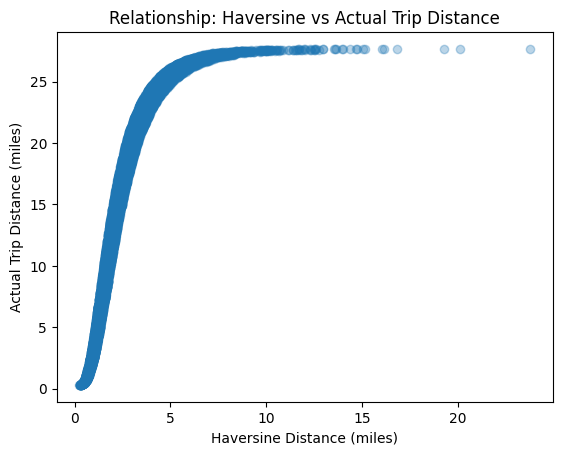

In [542]:
import matplotlib.pyplot as plt
plt.scatter(train['distance_miles'], train['trip_distance_miles'], alpha=0.3)
plt.xlabel("Haversine Distance (miles)")
plt.ylabel("Actual Trip Distance (miles)")
plt.title("Relationship: Haversine vs Actual Trip Distance")
plt.show()

In [543]:
# # Cluster Distribution Check: if any cluster dominates (bad sign):
# train['pickup_cluster'].value_counts(normalize=True).plot(kind='bar', figsize=(6,4))
# plt.title("Pickup Cluster Distribution (%)")
# plt.ylabel("Proportion")
# plt.show()

# train['dropoff_cluster'].value_counts(normalize=True).plot(kind='bar', figsize=(6,4))
# plt.title("Dropoff Cluster Distribution (%)")
# plt.ylabel("Proportion")
# plt.show()

In [544]:
# # Cluster vs Distance Relationship, This test tells us whether clusters help in prediction:

# train.groupby('pickup_cluster')['trip_distance_miles'].mean().plot(kind='bar', figsize=(6,4))
# plt.title("Mean Trip Distance by Pickup Cluster")
# plt.ylabel("Avg Distance (miles)")
# plt.show()

# train.groupby('dropoff_cluster')['trip_distance_miles'].mean().plot(kind='bar', figsize=(6,4))
# plt.title("Mean Trip Distance by Dropoff Cluster")
# plt.ylabel("Avg Distance (miles)")
# plt.show()


In [545]:
corr_pick = train['pickup_cluster'].corr(train['trip_distance_miles'])
corr_drop = train['dropoff_cluster'].corr(train['trip_distance_miles'])

corr_pick, corr_drop


(np.float64(0.008805814919823584), np.float64(0.002308327035152068))

In [546]:
# Remove trip_distance_miles from test only to avoid leakage
test = test.drop(columns=['trip_distance_miles'], errors='ignore')

# Encode traffic congestion (if present)
if 'traffic_congestion_level' in train.columns:
    order = {'Low': 0, 'Medium': 1, 'High': 2}
    train['traffic_congestion_level'] = train['traffic_congestion_level'].map(order).fillna(1)
    test['traffic_congestion_level'] = test['traffic_congestion_level'].map(order).fillna(1)

# One-hot encode categorical columns properly
categorical_cols = ['season']
train = pd.get_dummies(train, columns=categorical_cols)
test = pd.get_dummies(test, columns=categorical_cols)

# Align train and test columns
train, test = train.align(test, join='left', axis=1, fill_value=0)

# Split final X and y
X = train.drop(columns=['trip_distance_miles'])
y = train['trip_distance_miles']


In [547]:
print("Train Shape:", train.shape)
print("Test Shape:", test.shape)
print("Columns:", train.columns.tolist())

Train Shape: (14699, 41)
Test Shape: (300, 41)
Columns: ['pickup_datetime', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'passenger_count', 'trip_distance_miles', 'pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_dayofweek', 'is_weekend', 'distance_miles', 'near_JFK_pickup', 'near_JFK_drop', 'near_LGA_pickup', 'near_LGA_drop', 'near_EWR_pickup', 'near_EWR_drop', 'same_borough', 'pickup_is_Manhattan', 'drop_is_Manhattan', 'is_rush_hour', 'pickup_borough_Brooklyn', 'pickup_borough_Manhattan', 'pickup_borough_Other', 'pickup_borough_Staten Island', 'dropoff_borough_Brooklyn', 'dropoff_borough_Manhattan', 'dropoff_borough_Other', 'dropoff_borough_Staten Island', 'pickup_cluster', 'dropoff_cluster', 'is_holiday', 'snow_risk', 'season_fall', 'season_spring', 'season_summer', 'season_winter']


In [550]:
# datetime_cols = ['pickup_datetime', 'dropoff_datetime']

# for col in datetime_cols:
#     if col in X_train.columns:
#         X_train = X_train.drop(columns=[col])
#         X_val = X_val.drop(columns=[col])
#         test = test.drop(columns=[col])

non_numeric = X_train.select_dtypes(exclude=['number']).columns
print("Non numeric columns:", non_numeric)


Non numeric columns: Index(['pickup_borough_Brooklyn', 'pickup_borough_Manhattan',
       'pickup_borough_Other', 'pickup_borough_Staten Island',
       'dropoff_borough_Brooklyn', 'dropoff_borough_Manhattan',
       'dropoff_borough_Other', 'dropoff_borough_Staten Island', 'season_fall',
       'season_spring', 'season_summer', 'season_winter'],
      dtype='object')


In [552]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Target variable
y = train['trip_distance_miles']
X = train.drop(columns=['trip_distance_miles'])

datetime_cols = ['pickup_datetime', 'dropoff_datetime']
X = X.drop(columns=datetime_cols, errors='ignore')


# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = {}

def evaluate(model_name, model):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    
    results[model_name] = {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    print(f"{model_name} -> RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

# LightGBM
lgb_model = LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
evaluate("LightGBM", lgb_model)

# CatBoost
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=8, random_state=42, verbose=False)
evaluate("CatBoost", cat_model)

# XGBoost
xgb_model = XGBRegressor(
    n_estimators=500, learning_rate=0.05,
    max_depth=8, subsample=0.8,
    colsample_bytree=0.8, random_state=42,
    tree_method="hist"
)
evaluate("XGBoost", xgb_model)

# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=25,
    random_state=42,
    n_jobs=-1
)
evaluate("RandomForest", rf_model)

print("\nModel Comparison:", results)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 11759, number of used features: 37
[LightGBM] [Info] Start training from score 13.940122
LightGBM -> RMSE: 0.8268, MAE: 0.6627, R2: 0.9892
CatBoost -> RMSE: 0.8217, MAE: 0.6621, R2: 0.9893
XGBoost -> RMSE: 0.8821, MAE: 0.7042, R2: 0.9877
RandomForest -> RMSE: 0.8253, MAE: 0.6548, R2: 0.9892

Model Comparison: {'LightGBM': {'RMSE': np.float64(0.8268005006486607), 'MAE': 0.662735635679501, 'R2': 0.9891789685778869}, 'CatBoost': {'RMSE': np.float64(0.8216843275405795), 'MAE': 0.6620900280873616, 'R2': 0.989312473531855}, 'XGBoost': {'RMSE': np.float64(0.8821161425069936), 'MAE': 0.7042146470697559,

In [313]:
from catboost import CatBoostRegressor
import numpy as np

# Full data training
y = train['trip_distance_miles']
X = train.drop(columns=['trip_distance_miles'])

final_model = CatBoostRegressor(
    iterations=700,
    learning_rate=0.04,
    depth=8,
    random_state=42,
    verbose=False
)

final_model.fit(X, y)

# Predict on test
preds_test = final_model.predict(test)

# Prepare submission
submission = pd.DataFrame({
    'trip_distance_miles': preds_test
})

submission.to_csv('submission.csv', index=False)
print("Submission file saved successfully: submission.csv")


Submission file saved successfully: submission.csv


In [499]:
# Manhattan Distance
train['manhattan_distance'] = (
    abs(train['dropoff_latitude'] - train['pickup_latitude']) +
    abs(train['dropoff_longitude'] - train['pickup_longitude'])
)

test['manhattan_distance'] = (
    abs(test['dropoff_latitude'] - test['pickup_latitude']) +
    abs(test['dropoff_longitude'] - test['pickup_longitude'])
)

# Bearing Feature
from math import atan2, degrees, radians

def calculate_bearing(row):
    lon1, lat1, lon2, lat2 = map(radians, [
        row['pickup_longitude'], row['pickup_latitude'],
        row['dropoff_longitude'], row['dropoff_latitude']
    ])
    dlon = lon2 - lon1
    x = np.arctan2(
        np.sin(dlon) * np.cos(lat2),
        np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(dlon)
    )
    bearing = (degrees(x) + 360) % 360
    return bearing

train['bearing'] = train.apply(calculate_bearing, axis=1)
test['bearing'] = test.apply(calculate_bearing, axis=1)

print("Feature engineering complete!")
print(train.shape, test.shape)


Feature engineering complete!
(14699, 43) (300, 43)


In [500]:
# train[['manhattan_distance', 'bearing']].head()
# test[['manhattan_distance', 'bearing']].head()

print("manhattan_distance" in train.columns)
print("manhattan_distance" in test.columns)


True
True


In [501]:
train[['manhattan_distance', 'bearing']].describe()

,manhattan_distance,bearing
count,14699.000000,14699.000000
mean,0.053701,180.415799
std,0.036203,104.725662
min,0.004521,0.016996
25%,0.029674,90.216085
50%,0.044523,178.994703
75%,0.067211,272.925826
max,0.570359,359.962311


In [554]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
from catboost import CatBoostRegressor

y = train['trip_distance_miles']
X = train.drop(columns=['trip_distance_miles'])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_scores = []

# cat_params = {
#     'iterations': 800,
#     'learning_rate': 0.03,
#     'depth': 8,
#     'loss_function': 'RMSE',
#     'random_state': 42,
#     'verbose': False
# }

# cat_params = {
#     'iterations': 1200,
#     'learning_rate': 0.025,
#     'depth': 7,
#     'loss_function': 'RMSE',
#     'random_seed': 42,
#     'l2_leaf_reg': 3,
#     'subsample': 0.9,
#     'colsample_bylevel': 0.8,
#     'verbose': False
# }

cat_params = {
    'iterations': 800,
    'learning_rate': 0.03,
    'depth': 10,
    # 'l2_leaf_reg': 5,
    'random_state': 42,
    'loss_function': 'RMSE',
    'verbose': False
}

for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = CatBoostRegressor(**cat_params)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    rmse_scores.append(rmse)

print("CV RMSE:", np.mean(rmse_scores))


CV RMSE: 0.8441114393139472


In [511]:
# train = train.loc[:, ~train.columns.duplicated()]
# test = test.loc[:, ~test.columns.duplicated()]

print(train.shape, test.shape)

(14699, 43) (300, 43)


In [505]:
from catboost import CatBoostRegressor

y = train['trip_distance_miles']
X = train.drop(columns=['trip_distance_miles'])

final_params = {
    'iterations': 900,
    'learning_rate': 0.03,
    'depth': 9,
    'loss_function': 'RMSE',
    'random_state': 42,
    'verbose': False
}

final_model = CatBoostRegressor(**final_params)
final_model.fit(X, y)

print("Training complete.")


Training complete.


In [506]:
test_pred = final_model.predict(test)

submission = pd.DataFrame({
    "trip_distance_miles": test_pred
})

submission.to_csv("submission_catboost.csv", index=False)
print("Submission saved.")

Submission saved.


In [507]:
print("CV RMSE:", np.mean(rmse_scores))

CV RMSE: 0.8328113993642725


In [557]:
# import matplotlib.pyplot as plt
# importance = final_model.get_feature_importance()
# features = X.columns  # Not train.columns

# plt.figure(figsize=(6, 8))
# plt.barh(features, importance)
# plt.xlabel("Importance Score")
# plt.title("CatBoost Feature Importance")
# plt.show()


In [556]:
test.head()

,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,trip_distance_miles,pickup_year,pickup_month,pickup_day,pickup_hour,...,dropoff_borough_Other,dropoff_borough_Staten Island,pickup_cluster,dropoff_cluster,is_holiday,snow_risk,season_fall,season_spring,season_summer,season_winter
0,40.855567,-74.244521,40.891126,-74.208418,2,0,2024,1,28,17,...,False,False,8,7,0,1,False,False,False,True
1,40.895791,-74.190683,40.875638,-74.196187,1,0,2024,11,27,11,...,False,False,8,7,0,0,True,False,False,False
2,40.820683,-74.163929,40.867325,-74.221284,1,0,2024,5,11,2,...,False,False,8,7,0,0,False,True,False,False
3,40.685081,-73.774795,40.640616,-73.744560,1,0,2024,3,11,18,...,False,False,7,9,0,0,False,True,False,False
4,40.645333,-73.990859,40.607227,-74.009520,4,0,2024,9,3,1,...,True,False,9,6,0,0,True,False,False,False


In [559]:
# print(df.columns.tolist())

test_df = test.copy()  # ensure raw test data exists as `test`
# Then apply 100% same feature engineering steps here

missing_cols = set(X_full.columns) - set(test_df.columns)
extra_cols = set(test_df.columns) - set(X_full.columns)

print("Missing in test:", missing_cols)
print("Extra in test:", extra_cols)

for col in missing_cols:
    test_df[col] = 0

test_df = test_df[X_full.columns]  # reorder & keep only used features




Missing in test: {'pickup_datetime'}
Extra in test: {'trip_distance_miles'}


In [560]:
from catboost import CatBoostRegressor
import pandas as pd

# Separate full train data
y_full = train['trip_distance_miles']
X_full = train.drop(columns=['trip_distance_miles'])

# Final model with optimal config
final_model = CatBoostRegressor(
    iterations=1200,
    learning_rate=0.03,
    depth=10,
    loss_function='RMSE',
    random_seed=42,
    l2_leaf_reg=3,
    subsample=0.9,
    colsample_bylevel=0.8,
    verbose=False
)

# Train on 100% training data
final_model.fit(X_full, y_full)

# Predict using full test set
test_predictions = final_model.predict(test_df)

# Create submission dataframe
submission = pd.DataFrame({
    'trip_distance_miles': test_predictions
})

# Save file
submission.to_csv('submission.csv', index=False)

submission.head()


,trip_distance_miles
0,20.409491
1,7.591492
2,24.270658
3,22.157676
4,19.128162


In [565]:
cat_features = ['pickup_cluster', 'dropoff_cluster']

model = CatBoostRegressor(
    iterations=1200,
    learning_rate=0.025,
    depth=7,
    loss_function='RMSE',
    random_seed=42,
    l2_leaf_reg=3,
    subsample=0.9,
    colsample_bylevel=0.8,
    cat_features=cat_features,
    verbose=False
)

remove_cols = [
    'log_speed', 'distance_per_minute', 'avg_speed',
    'rush_weekend', 'direction_complexity'
]

for col in remove_cols:
    if col in X_full.columns:
        X_full = X_full.drop(columns=[col])
    if col in test_df.columns:
        test_df = test_df.drop(columns=[col])

from sklearn.metrics import mean_squared_error
import numpy as np

# Log-transform target
y_full_log = np.log1p(y_full)

model.fit(X_full, y_full_log)

# Training prediction
train_pred_log = model.predict(X_full)
train_pred = np.expm1(train_pred_log)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_full, train_pred))
print("Training RMSE:", rmse)



Training RMSE: 0.7632477237974745


In [566]:
# Predict on test set (log space -> actual space)
test_pred_log = model.predict(test_df)
test_pred = np.expm1(test_pred_log)

# Negative or unrealistic predictions → safety clip
test_pred = np.clip(test_pred, 0, None)

# Create submission file
submission = pd.DataFrame({
    'trip_distance_miles': test_pred
})

file_name = f"submission_catboost_final_{np.round(rmse, 4)}.csv"
submission.to_csv(file_name, index=False)

print("Submission saved as:", file_name)
print(submission.head())


Submission saved as: submission_catboost_final_0.7632.csv
   trip_distance_miles
0            20.575319
1             7.309726
2            24.422636
3            22.407634
4            19.071991


In [ ]:
# Stacking pipeline (fixed for older LightGBM / sklearn versions)
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from lightgbm import early_stopping, log_evaluation

RND = 42
NFOLDS = 5

# 1) Prepare data
y = train['trip_distance_miles'].copy()
X = train.drop(columns=['trip_distance_miles']).copy()
test_X = test.copy()

# Defensive: drop datetime columns if present
for c in ['pickup_datetime', 'dropoff_datetime']:
    if c in X.columns:
        X = X.drop(columns=[c])
    if c in test_X.columns:
        test_X = test_X.drop(columns=[c])

# Reduced stable feature set removal (if present)
remove_cols = ['log_speed', 'distance_per_minute', 'avg_speed', 'rush_weekend', 'direction_complexity']
for c in remove_cols:
    if c in X.columns: X = X.drop(columns=[c])
    if c in test_X.columns: test_X = test_X.drop(columns=[c])

# Align columns
X, test_X = X.align(test_X, join='left', axis=1, fill_value=0)
print("Train shape:", X.shape, " Test shape:", test_X.shape)

# 2) Placeholders for OOF / test preds
oof_cat = np.zeros(len(X))
oof_lgb = np.zeros(len(X))
test_cat_preds = np.zeros(len(test_X))
test_lgb_preds = np.zeros(len(test_X))

kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=RND)

# Categorical features (only keep existing ones)
possible_cat = ['pickup_borough_enc', 'dropoff_borough_enc', 'pickup_cluster', 'dropoff_cluster']
cat_features = [c for c in possible_cat if c in X.columns]
print("CatBoost will use categorical features:", cat_features)

# For LightGBM we will pass names if they exist
lgb_cat_features = [c for c in possible_cat if c in X.columns]

# 3) CV loop
cat_fold_rmse = []
lgb_fold_rmse = []

for fold, (tr_idx, val_idx) in enumerate(kf.split(X), 1):
    print(f"\n---- Fold {fold} ----")
    X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

    # ----- CatBoost -----
    cat_model = CatBoostRegressor(
        iterations=900,
        learning_rate=0.03,
        depth=8,
        loss_function='RMSE',
        random_seed=RND,
        l2_leaf_reg=3,
        subsample=0.9,
        colsample_bylevel=0.8,
        verbose=False
    )
    if len(cat_features) > 0:
        cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), cat_features=cat_features, verbose=100)
    else:
        cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), verbose=100)

    val_pred_cat = cat_model.predict(X_val)
    oof_cat[val_idx] = val_pred_cat
    test_cat_preds += cat_model.predict(test_X) / NFOLDS

    rmse_cat = np.sqrt(mean_squared_error(y_val, val_pred_cat))
    cat_fold_rmse.append(rmse_cat)
    print(f"CatBoost fold RMSE: {rmse_cat:.4f}")

    # ----- LightGBM -----
    lgb_model = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.03,
        max_depth=-1,
        num_leaves=64,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=RND,
        n_jobs=-1
    )

    # Fit (older versions: don't use early_stopping_rounds keyword)
    if len(lgb_cat_features) > 0:
        # ensure categorical columns are pandas 'category' dtype for LightGBM if possible
        for c in lgb_cat_features:
            if len(lgb_cat_features) > 0:
                lgb_model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                    categorical_feature=lgb_cat_features,
                    callbacks=[
                        early_stopping(stopping_rounds=50),
                        log_evaluation(period=100)
                    ]
                )
            else:
                lgb_model.fit(
                    X_tr, y_tr,
                    eval_set=[(X_val, y_val)],
                    callbacks=[
                        early_stopping(stopping_rounds=50),
                        log_evaluation(period=100)
                    ]
                )


    # Use best_iteration_ if present otherwise default predict
    if hasattr(lgb_model, "best_iteration_") and lgb_model.best_iteration_ is not None:
        val_pred_lgb = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration_)
        test_pred_fold = lgb_model.predict(test_X, num_iteration=lgb_model.best_iteration_)
    else:
        val_pred_lgb = lgb_model.predict(X_val)
        test_pred_fold = lgb_model.predict(test_X)

    oof_lgb[val_idx] = val_pred_lgb
    test_lgb_preds += test_pred_fold / NFOLDS

    rmse_lgb = np.sqrt(mean_squared_error(y_val, val_pred_lgb))
    lgb_fold_rmse.append(rmse_lgb)
    print(f"LightGBM fold RMSE: {rmse_lgb:.4f}")

# CV summary
print("\nCatBoost CV RMSE (mean):", np.mean(cat_fold_rmse))
print("LightGBM CV RMSE (mean):", np.mean(lgb_fold_rmse))

# 4) Meta model on OOF
meta_X = np.vstack([oof_cat, oof_lgb]).T
meta_y = y.values

meta_model = Ridge(alpha=1.0, random_state=RND)
meta_model.fit(meta_X, meta_y)

meta_oof_pred = meta_model.predict(meta_X)
meta_rmse = np.sqrt(mean_squared_error(meta_y, meta_oof_pred))
print("Stacked (OOF) RMSE:", meta_rmse)

# 5) Train base models on full data and predict test
# CatBoost final
final_cat = CatBoostRegressor(
    iterations=900,
    learning_rate=0.03,
    depth=8,
    loss_function='RMSE',
    random_seed=RND,
    l2_leaf_reg=3,
    subsample=0.9,
    colsample_bylevel=0.8,
    verbose=False
)
if len(cat_features) > 0:
    final_cat.fit(X, y, cat_features=cat_features, verbose=100)
else:
    final_cat.fit(X, y, verbose=100)
final_cat_test = final_cat.predict(test_X)

# LightGBM final
final_lgb = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND,
    n_jobs=-1
)
# ensure test_X dtypes OK for categorical features
if len(lgb_cat_features) > 0:
    for c in lgb_cat_features:
        if test_X[c].dtype != 'category':
            test_X[c] = test_X[c].astype('category')
final_lgb.fit(X, y)
if hasattr(final_lgb, "best_iteration_") and final_lgb.best_iteration_ is not None:
    final_lgb_test = final_lgb.predict(test_X, num_iteration=final_lgb.best_iteration_)
else:
    final_lgb_test = final_lgb.predict(test_X)

# Stack final preds
final_meta_input = np.vstack([final_cat_test, final_lgb_test]).T
final_stack_pred = meta_model.predict(final_meta_input)
final_stack_pred = np.clip(final_stack_pred, 0, None)

# 6) Save submission
submission = pd.DataFrame({'trip_distance_miles': final_stack_pred})
submission.to_csv('submission_stacked.csv', index=False)
print("\nSaved submission_stacked.csv — preview:")
print(submission.head())
